### KNN K邻近点算法用户图像识别的原理
图像识别，本质上也是数据分类，也即把每一张图像归类，因此KNN算法可以应用于图像识别。
KNN是基于距离的判别算法-样本距离。
通常每一个样本都是一维向量的形式（二维、三维、多维数据都可以转换为一维向量）。
衡量一维向量之间的距离，通常有欧式距离，余弦距离、汉明距离等，
**其中欧式距离又是最常用的距离度量方法。**
K值。K值决定寻找训练样本中最接近待分类样本的样本个数，比如K值取5，那么对于每一个待分类样本，都从训练样本中寻找5个与其距离最接近的样本，然后统计这5个样本中各个类别的数量，数量最多的类别则认为是待分类样本的类别。K值没有固定的取值，通常在一开始取5~10，然后多尝试几次，根据识别的正确率来调整K值。
参考：https://zhuanlan.zhihu.com/p/355740954

In [64]:
import os
import glob
import cv2 
import math
import random 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from scipy.linalg import svd
from numpy import linalg as LA

%matplotlib inline

### 数据预处理

In [59]:
path = glob.glob("E:/face_dectection/*/*.jpg")

In [60]:
len(path)

2061

In [65]:
random.shuffle(path)

In [31]:
X=[]
count=0
for img in path:
    if "jpg" in img:
        try:
            n = cv2.imread(img)#发送读取错误时跳过
            gray = cv2.cvtColor(n,cv2.COLOR_BGR2GRAY)
        except:
            X.append(np.zeros((50,50)))#填充错误值
            continue
        gray = cv2.resize(gray,(50,50))
        X.append(gray)
        count=count+1
print(count)

1891


In [32]:
print(len(X))#5126张图片
print(type(X[0]))
print(X[0].shape)
print(X[0])

2061
<class 'numpy.ndarray'>
(50, 50)
[[199 199 198 ... 197 197 197]
 [199 199 201 ... 197 197 197]
 [199 198 201 ... 196 197 197]
 ...
 [197 196  30 ... 183 182 181]
 [196 196  35 ... 182 181 181]
 [196 196  38 ... 181 180 180]]


In [80]:
sizeImg = X[0].shape
#创建X个与图片大小一样的0位数组
A = np.zeros((sizeImg[0]*sizeImg[1],len(X)))
for i in range(0, len(X)):
    tmp = (np.array(X[i]).reshape(-1))#转化为一维数组
    A[:,i] = np.array(tmp)

In [81]:
A.shape

(2500, 2061)

In [66]:
print(len(path))

2061


In [71]:
path2=path[1:20]
print(path2)

['E:/face_dectection\\happy\\recgonize_happy382.jpg', 'E:/face_dectection\\happy\\recgonize_happy411.jpg', 'E:/face_dectection\\happy\\recgonize_happy320.jpg', 'E:/face_dectection\\surprise\\recgonize_surprise2.jpg', 'E:/face_dectection\\anger\\recgonize_anger39.jpg', 'E:/face_dectection\\surprise\\recgonize_surprise152.jpg', 'E:/face_dectection\\sad\\recgonize_sad6.jpg', 'E:/face_dectection\\anger\\recgonize_anger257.jpg', 'E:/face_dectection\\anger\\recgonize_anger394.jpg', 'E:/face_dectection\\sad\\recgonize_sad278.jpg', 'E:/face_dectection\\happy\\recgonize_happy65.jpg', 'E:/face_dectection\\anger\\recgonize_anger347.jpg', 'E:/face_dectection\\anger\\recgonize_anger349.jpg', 'E:/face_dectection\\surprise1\\recgonize_surprise6.jpg', 'E:/face_dectection\\sad\\recgonize_sad23.jpg', 'E:/face_dectection\\happy\\recgonize_happy368.jpg', 'E:/face_dectection\\anger\\recgonize_anger80.jpg', 'E:/face_dectection\\anger\\recgonize_anger274.jpg', 'E:/face_dectection\\anger\\recgonize_anger155.j

In [72]:
#建立标准
Y_map_num = np.zeros((len(X)))
i = 0
for img in path:
    if "jpg" in img:
        if "happy" in img:
            Y_map_num[i]=1
        elif "sad" in img:
            Y_map_num[i]=2
        elif "anger" in img:
            Y_map_num[i]=3
        elif "surprise" in img:
            Y_map_num[i]=4
        elif "fear" in img:
            Y_map_num[i]=5
        i = i+1

In [69]:
#建立标准
Y_map_label = [0 for x in range(len(X))]
i = 0
for img in path:
    if "jpg" in img:
        if "happy" in img:
            Y_map_label[i]=("happy")
        elif "sad" in img:
            Y_map_label[i]=("sad")
        elif "anger" in img:
            Y_map_label[i]=("anger")
        elif "surprise" in img:
            Y_map_label[i]=("surprise")
        elif "fear" in img:
            Y_map_label[i]=("fear")
        i = i+1

In [73]:
print(Y_map_label[1:20])
print(Y_map_num[1:20])

['happy', 'happy', 'happy', 'surprise', 'anger', 'surprise', 'sad', 'anger', 'anger', 'sad', 'happy', 'anger', 'anger', 'surprise', 'sad', 'happy', 'anger', 'anger', 'anger']
[1. 1. 1. 4. 3. 4. 2. 3. 3. 2. 1. 3. 3. 4. 2. 1. 3. 3. 3.]


In [79]:
print(len(Y_map_num))

2061


#### 方式一将标签和数字做映射

In [82]:
#划分训练集和测试集， A--image, Y--leibei, train_X, train_Y;--- model,  testX---model---predY ---test_Y
A=A.T
train_X,test_X,train_Y,test_Y = train_test_split(A, Y_map_num, test_size=0.2, random_state=13)
train_X.shape,test_X.shape,train_Y.shape,test_Y.shape

((1648, 2500), (413, 2500), (1648,), (413,))

In [77]:
import sklearn
help(sklearn.preprocessing.StandardScaler)

Help on class StandardScaler in module sklearn.preprocessing._data:

class StandardScaler(sklearn.base._OneToOneFeatureMixin, sklearn.base.TransformerMixin, sklearn.base.BaseEstimator)
 |  StandardScaler(*, copy=True, with_mean=True, with_std=True)
 |  
 |  Standardize features by removing the mean and scaling to unit variance.
 |  
 |  The standard score of a sample `x` is calculated as:
 |  
 |      z = (x - u) / s
 |  
 |  where `u` is the mean of the training samples or zero if `with_mean=False`,
 |  and `s` is the standard deviation of the training samples or one if
 |  `with_std=False`.
 |  
 |  Centering and scaling happen independently on each feature by computing
 |  the relevant statistics on the samples in the training set. Mean and
 |  standard deviation are then stored to be used on later data using
 |  :meth:`transform`.
 |  
 |  Standardization of a dataset is a common requirement for many
 |  machine learning estimators: they might behave badly if the
 |  individual fea

In [83]:
#进行归一化和标准化
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_X = sc.fit_transform(train_X)
test_X = sc.transform(test_X)

In [84]:
# Fitting K-NN to the Training set
from sklearn.neighbors import KNeighborsClassifier
#KNeighborsClassifier()

classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(train_X, train_Y)

KNeighborsClassifier()

In [85]:
pred_Y = classifier.predict(test_X)
test_Y = test_Y.tolist()

In [86]:
y_test_np = np.asarray(test_Y)
y_test_np

array([1., 1., 2., 2., 2., 4., 3., 3., 3., 1., 4., 4., 1., 4., 2., 2., 4.,
       1., 2., 5., 3., 2., 2., 1., 1., 4., 1., 3., 3., 4., 5., 3., 3., 5.,
       2., 3., 4., 3., 5., 3., 3., 5., 1., 1., 1., 4., 3., 2., 4., 3., 2.,
       1., 1., 5., 2., 1., 1., 1., 5., 4., 2., 1., 3., 3., 1., 5., 2., 1.,
       4., 2., 4., 3., 2., 3., 4., 3., 4., 5., 5., 2., 4., 4., 1., 3., 5.,
       3., 1., 2., 3., 3., 2., 1., 2., 2., 2., 2., 4., 3., 3., 3., 3., 3.,
       3., 1., 2., 5., 3., 2., 1., 4., 1., 1., 4., 1., 3., 4., 4., 4., 4.,
       5., 4., 2., 2., 4., 4., 1., 2., 2., 2., 4., 5., 1., 4., 2., 3., 3.,
       1., 5., 5., 2., 4., 5., 5., 4., 5., 2., 5., 2., 1., 1., 4., 1., 5.,
       4., 2., 5., 3., 2., 2., 2., 4., 1., 5., 1., 5., 3., 5., 2., 5., 5.,
       2., 4., 1., 5., 4., 2., 4., 5., 5., 2., 2., 5., 4., 1., 1., 1., 2.,
       3., 5., 4., 4., 4., 3., 2., 3., 2., 2., 2., 3., 5., 5., 4., 1., 4.,
       5., 1., 4., 3., 1., 3., 4., 3., 5., 5., 5., 3., 1., 2., 5., 1., 2.,
       1., 2., 2., 4., 5.

In [87]:
print(pred_Y)

[1. 1. 4. 2. 2. 2. 4. 4. 2. 4. 2. 5. 1. 2. 5. 4. 1. 3. 3. 4. 5. 2. 4. 2.
 2. 2. 1. 2. 1. 4. 1. 2. 1. 2. 1. 2. 5. 3. 3. 2. 4. 1. 2. 1. 4. 3. 4. 5.
 2. 3. 2. 1. 4. 5. 4. 2. 2. 2. 1. 1. 4. 3. 1. 3. 4. 1. 2. 5. 1. 2. 4. 1.
 1. 3. 4. 4. 1. 3. 1. 3. 1. 2. 4. 4. 4. 1. 1. 1. 1. 4. 5. 2. 4. 1. 3. 4.
 2. 1. 3. 3. 5. 1. 3. 5. 2. 1. 3. 3. 1. 2. 4. 3. 3. 1. 4. 1. 3. 2. 2. 2.
 4. 5. 4. 1. 2. 1. 4. 2. 3. 2. 2. 2. 1. 2. 1. 2. 4. 2. 1. 3. 4. 5. 2. 2.
 2. 4. 1. 4. 2. 4. 1. 2. 2. 1. 2. 3. 2. 1. 3. 1. 2. 3. 2. 3. 1. 2. 1. 2.
 1. 3. 2. 3. 2. 5. 3. 1. 4. 3. 1. 5. 4. 2. 3. 4. 3. 3. 2. 5. 4. 4. 1. 1.
 3. 5. 4. 1. 4. 3. 2. 4. 1. 4. 4. 2. 2. 1. 5. 3. 2. 2. 4. 1. 3. 4. 3. 3.
 3. 5. 2. 2. 4. 2. 4. 2. 3. 4. 2. 5. 2. 1. 3. 4. 1. 5. 3. 2. 2. 2. 3. 3.
 4. 1. 1. 2. 4. 5. 4. 1. 3. 4. 4. 3. 5. 2. 1. 1. 1. 5. 3. 1. 3. 4. 1. 3.
 1. 3. 4. 3. 2. 1. 1. 4. 1. 4. 4. 4. 4. 1. 5. 4. 2. 3. 3. 5. 2. 1. 1. 1.
 3. 1. 4. 3. 1. 2. 2. 4. 3. 3. 3. 2. 5. 5. 3. 4. 1. 3. 4. 4. 4. 1. 1. 1.
 4. 2. 4. 1. 1. 4. 1. 3. 4. 4. 1. 4. 3. 4. 3. 2. 4.

In [89]:
len(Y_map_label)

2061

#### 方式2： 直接进行标签的匹配

In [94]:
#划分训练集和测试集， A--image, Y--leibei, train_X, train_Y;--- model,  testX---model---predY ---test_Y
from sklearn.neighbors import KNeighborsClassifier
#KNeighborsClassifier()
#进行归一化和标准化
from sklearn.preprocessing import StandardScaler

A=A.T
train_X,test_X,train_Y,test_Y = train_test_split(A, Y_map_label, test_size=0.2, random_state=13)
# train_X.shape,test_X.shape,train_Y.shape,test_Y.shape

sc = StandardScaler()
train_X = sc.fit_transform(train_X)
test_X = sc.transform(test_X)
# Fitting K-NN to the Training set
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(train_X, train_Y)

KNeighborsClassifier()

In [95]:
pred_Y = classifier.predict(test_X)

In [100]:
print(pred_Y)
print(len(pred_Y))

['anger' 'fear' 'surprise' 'fear' 'anger' 'sad' 'surprise' 'surprise'
 'sad' 'surprise' 'sad' 'fear' 'fear' 'sad' 'fear' 'surprise' 'happy'
 'anger' 'anger' 'fear' 'fear' 'sad' 'surprise' 'sad' 'sad' 'sad' 'happy'
 'sad' 'happy' 'surprise' 'happy' 'sad' 'anger' 'sad' 'happy' 'sad' 'fear'
 'anger' 'anger' 'sad' 'surprise' 'happy' 'anger' 'happy' 'surprise'
 'anger' 'surprise' 'fear' 'sad' 'anger' 'sad' 'happy' 'surprise' 'fear'
 'surprise' 'sad' 'sad' 'sad' 'happy' 'happy' 'fear' 'anger' 'happy'
 'anger' 'surprise' 'happy' 'fear' 'fear' 'happy' 'sad' 'surprise' 'happy'
 'happy' 'anger' 'surprise' 'surprise' 'happy' 'anger' 'happy' 'anger'
 'happy' 'sad' 'surprise' 'surprise' 'surprise' 'happy' 'happy' 'anger'
 'happy' 'surprise' 'fear' 'sad' 'surprise' 'happy' 'anger' 'surprise'
 'sad' 'happy' 'anger' 'anger' 'fear' 'happy' 'anger' 'fear' 'sad' 'happy'
 'anger' 'anger' 'happy' 'sad' 'surprise' 'anger' 'anger' 'fear'
 'surprise' 'fear' 'anger' 'sad' 'sad' 'sad' 'surprise' 'fear' 'surpris

In [98]:
print(test_Y)
print(len(test_Y))

['happy', 'happy', 'sad', 'sad', 'sad', 'surprise', 'anger', 'anger', 'anger', 'happy', 'surprise', 'surprise', 'happy', 'surprise', 'sad', 'sad', 'surprise', 'happy', 'sad', 'fear', 'anger', 'sad', 'sad', 'happy', 'happy', 'surprise', 'happy', 'anger', 'anger', 'surprise', 'fear', 'anger', 'anger', 'fear', 'sad', 'anger', 'surprise', 'anger', 'fear', 'anger', 'anger', 'fear', 'happy', 'happy', 'happy', 'surprise', 'anger', 'sad', 'surprise', 'anger', 'sad', 'happy', 'happy', 'fear', 'sad', 'happy', 'happy', 'happy', 'fear', 'surprise', 'sad', 'happy', 'anger', 'anger', 'happy', 'fear', 'sad', 'happy', 'surprise', 'sad', 'surprise', 'anger', 'sad', 'anger', 'surprise', 'anger', 'surprise', 'fear', 'fear', 'sad', 'surprise', 'surprise', 'happy', 'anger', 'fear', 'anger', 'happy', 'sad', 'anger', 'anger', 'sad', 'happy', 'sad', 'sad', 'sad', 'sad', 'surprise', 'anger', 'anger', 'anger', 'anger', 'anger', 'anger', 'happy', 'sad', 'fear', 'anger', 'sad', 'happy', 'surprise', 'happy', 'happ

In [108]:
### 进行效果评价
from sklearn.metrics import accuracy_score 
from sklearn.metrics import auc 
from sklearn.metrics import f1_score 
from sklearn.metrics import precision_score

acc=accuracy_score(test_Y, pred_Y)
pre=precision_score(test_Y, pred_Y,average='micro')
score=f1_score(test_Y, pred_Y,average='micro')
# area=auc(test_Y, pred_Y)

print(acc)
print(pre)
print(score)
# print(area)

0.1937046004842615
0.1937046004842615
0.1937046004842615


Found 80 correct labels


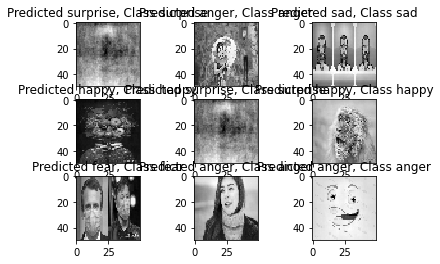

In [111]:
correct = np.where(pred_Y==test_Y)[0]
print ("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[40:49]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(50,50), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(pred_Y[correct], test_Y[correct]))

In [ ]:
#### 参考：

In [ ]:
分类模型的评价指标：https://zhuanlan.zhihu.com/p/110015537
sklearn用于模型评价：https://blog.csdn.net/weixin_44436677/article/details/105985358